# Prepare dataset

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# local path
# FAULT_DATA_DIR = "D:\\Windows_Storage\\Storage\\Github\\phm_etching_01M01-02\\M02_Groups_same_length\\fault"
# HEALTHY_DATA_DIR = "D:\\Windows_Storage\\Storage\\Github\\phm_etching_01M01-02\\M02_Groups_same_length\\healthy"

# server path
FAULT_DATA_DIR = "C:\\Users\\User\\Desktop\\Ricardo\\phm_etching_01M01-02\\M02_Groups_same_length\\fault"
HEALTHY_DATA_DIR = "C:\\Users\\User\Desktop\\Ricardo\\phm_etching_01M01-02\\M02_Groups_same_length\\healthy"

HEALTHY_DATA_SAMPLE_NUM = 10

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn

In [2]:
os.chdir(FAULT_DATA_DIR)

# read in fault data
for fileIndex, file in enumerate(tqdm(os.listdir())):
    if fileIndex == 0:
        data_all = pd.read_csv(file, encoding="utf8")
    else:
        data_import = pd.read_csv(file, encoding="utf8")
        data_all = data_all.append(data_import, ignore_index = True)
        
os.chdir(HEALTHY_DATA_DIR)
healthy_file_list = os.listdir()
np.random.shuffle(healthy_file_list)

for fileIndex, file in enumerate(tqdm(healthy_file_list[:HEALTHY_DATA_SAMPLE_NUM])):
    data_import = pd.read_csv(file, encoding="utf8")
    data_all = data_all.append(data_import, ignore_index = True)
    
data_all.replace

100%|██████████| 10/10 [00:00<00:00, 50.45it/s]


<bound method DataFrame.replace of                time   Tool     Lot-runnum  stage     Lot      runnum  recipe  \
0      1.805567e+07  01M02  9174-11470110    1.0  9174.0  11470110.0    67.0   
1      1.805204e+07  01M02  9174-11470110    1.0  9174.0  11470110.0    67.0   
2      1.805320e+07  01M02  9174-11470110    1.0  9174.0  11470110.0    67.0   
3      1.805252e+07  01M02  9174-11470110    1.0  9174.0  11470110.0    67.0   
4      1.805302e+07  01M02  9174-11470110    1.0  9174.0  11470110.0    67.0   
...             ...    ...            ...    ...     ...         ...     ...   
35170  3.176944e+07  01M02  2137-12334653   88.0  2137.0  12334653.0    68.0   
35171  3.176964e+07  01M02  2137-12334653   88.0  2137.0  12334653.0    68.0   
35172  3.176986e+07  01M02  2137-12334653   88.0  2137.0  12334653.0    68.0   
35173  3.176953e+07  01M02  2137-12334653   88.0  2137.0  12334653.0    68.0   
35174  3.176858e+07  01M02  2137-12334653   88.0  2137.0  12334653.0    68.0   

    

In [3]:
# configurations
SEQ_LENGTH = 500

In [4]:
# create datasets with given sequence length
def sliding_windows(data, seq_length, selected_column):
    x = []
    y = []
    
    # calculate max min for each column
    data_temp = data.drop(columns=['time', 'Tool', 'Lot', 'Lot-runnum'])
    
    column_list = data_temp.columns.tolist()
    max_value_list = data_temp.max().tolist()
    min_value_list = data_temp.min().tolist()
    
    # normalize the data
    for column in data.columns:
        if column in ['time', 'Tool', 'Lot', 'Lot-runnum']:
            continue
            
        # x ′ = ( x − x m i n ) / ( x m a x − x m i n )
        column_index = column_list.index(column)
        data[column] = data[column].apply(lambda x: \
                                          (x - min_value_list[column_index]) / (max_value_list[column_index] - \
                                                                   min_value_list[column_index]))
        
#     print(data.head(5))

    for i in tqdm(range(len(data)-seq_length-1)):
        # create x and y 
        data_x = data.iloc[i:(i+seq_length), :]
        data_y = data.loc[[(i+seq_length)], [selected_column]]
        
        # skip if contains for than two Lot-runnum and np.nan appears in y
        if data_x["Lot-runnum"].nunique() > 1:
            continue
            
        # drop nan value
        if data_y[selected_column].isnull().values.any() or\
        data_x.isnull().values.any() :
            continue
        
        # drop unneccessary columns
        data_x.drop(columns=['time', 'Tool', 'Lot', 'TTF_FlowCool Pressure Dropped Below Limit',
       'TTF_Flowcool Pressure Too High Check Flowcool Pump', 'TTF_Flowcool leak', 'Lot-runnum'],
                     inplace=True)
        
        x.append(data_x)
        y.append(data_y)
        

    return np.array(x),np.array(y)

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = SEQ_LENGTH
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [6]:
# activate cuda

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()
print(is_cuda)

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True


# TTF_FlowCool Pressure Dropped Below Limit

In [7]:
SELECTED_COLUMN = 'TTF_FlowCool Pressure Dropped Below Limit'
x, y = sliding_windows(data_all, SEQ_LENGTH, SELECTED_COLUMN)
y = np.squeeze(y, axis=2)

print(x.shape, y.shape)

  0%|          | 0/34674 [00:00<?, ?it/s]c:\users\user\anaconda3\envs\nlp\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
100%|██████████| 34674/34674 [00:38<00:00, 907.14it/s] 


(10625, 500, 21) (10625, 1)


In [8]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


print(trainX.shape, trainY.shape, "\n", testX.shape, testY.shape)

torch.Size([7118, 500, 21]) torch.Size([7118, 1]) 
 torch.Size([3507, 500, 21]) torch.Size([3507, 1])


In [16]:
num_epochs = 2000
learning_rate = 0.01

input_size = 21
hidden_size = 5
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
#     print(outputs)
#     print(trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        

Epoch: 0, loss: 0.09758
Epoch: 100, loss: 0.00264
Epoch: 200, loss: 0.00232
Epoch: 300, loss: 0.00211
Epoch: 400, loss: 0.05306
Epoch: 500, loss: 0.00530
Epoch: 600, loss: 0.00511
Epoch: 700, loss: 0.00500
Epoch: 800, loss: 0.00492
Epoch: 900, loss: 0.00483
Epoch: 1000, loss: 0.00470
Epoch: 1100, loss: 0.00450
Epoch: 1200, loss: 0.00394
Epoch: 1300, loss: 0.00297
Epoch: 1400, loss: 0.00202
Epoch: 1500, loss: 0.00140
Epoch: 1600, loss: 0.00115
Epoch: 1700, loss: 0.00101
Epoch: 1800, loss: 0.00091
Epoch: 1900, loss: 0.00233


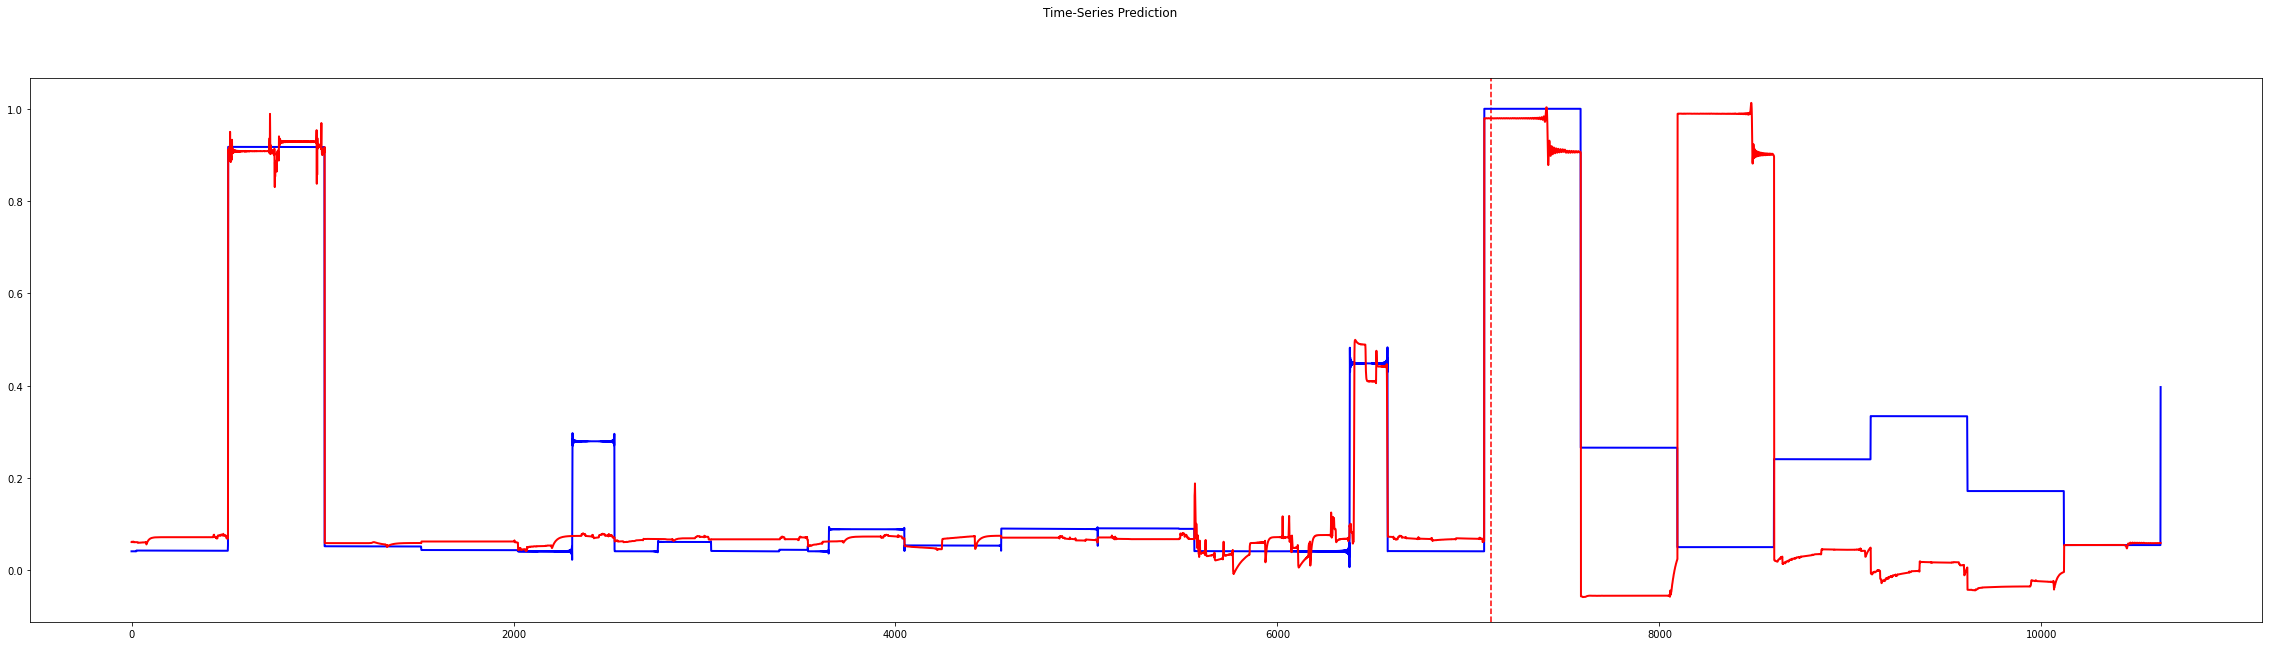

In [24]:
# prediction
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(40,10))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color="blue", linewidth=2)
plt.plot(data_predict, color="red", linewidth=2)
plt.suptitle('Time-Series Prediction')
plt.savefig("C:/Users/User/Desktop/Ricardo/PHM_ion-mill-etch-tool/Graphs/TTF_FlowCoolPressureDroppedBelowLimit.svg", format='svg', bbox_inches="tight")
plt.show()